# Model Fairness Testing & Bias Mitigation
Objective: Explore toolings and frameworks for Fairness Testing


In [27]:
#General imports
import os
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

#Project specific imports
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from interpret import preserve
from interpret.blackbox import MorrisSensitivity
from interpret.blackbox import ShapKernel
from fairml import audit_model
from fairml import plot_dependencies
import pickle
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
%%time
# Using an open source dataset for predicting peoples income
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1

# pick sensitive features
sex = data.data['sex']
race = data.data['race']


CPU times: user 13 ms, sys: 20.9 ms, total: 33.9 ms
Wall time: 508 ms


In [30]:
%%time
# Train model
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

# Make prediction
y_pred = classifier.predict(X)

# p.s. yes I know I didn't split the data properly, we're just focusing on the toolings not the actual results

CPU times: user 161 ms, sys: 25.2 ms, total: 186 ms
Wall time: 200 ms


## Using FairLearn to explore metrics by group

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>]],
      dtype=object)

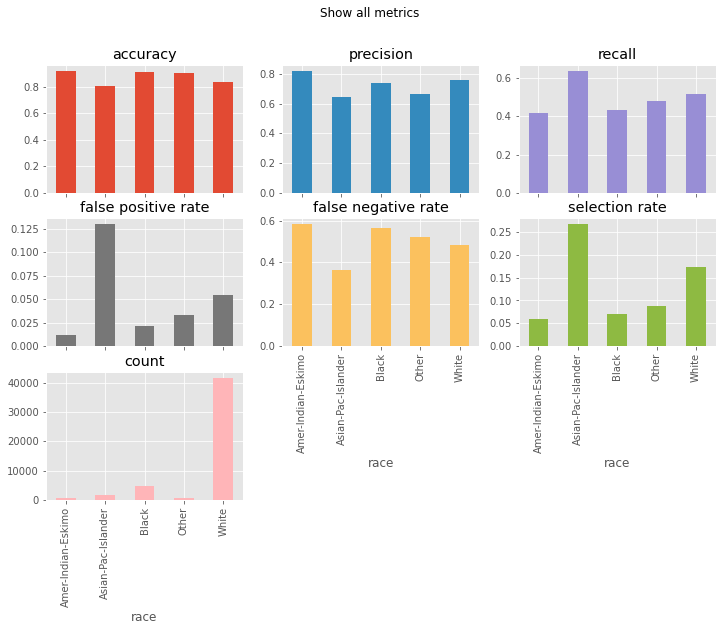

In [8]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count}

# Get metrics by race
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=race)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>]],
      dtype=object)

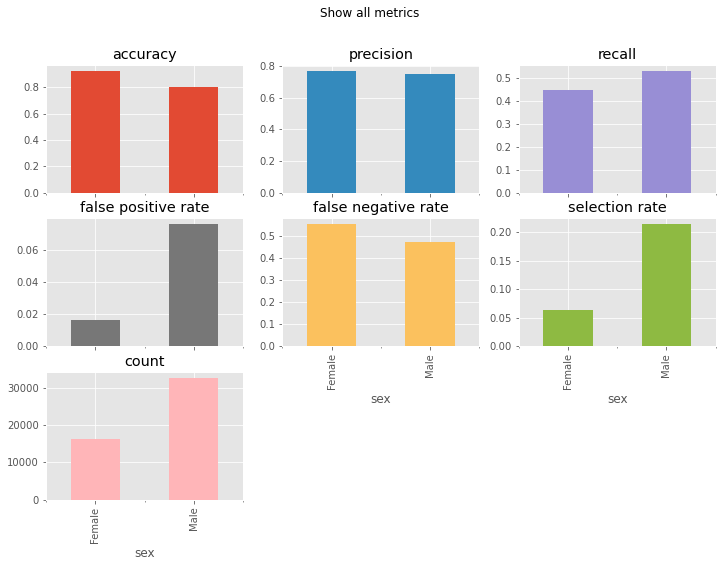

In [47]:
# Get metrics by sex
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=sex)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## Mitigating Bias via Demographic Parity
The Exponentiated Gradient mitigation technique used fits the provided classifier using Demographic Parity as the objective, leading to a vastly reduced difference in selection rate.


In [48]:
%%time
%%capture output

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
constraint = DemographicParity()

# Re-train model with mitigator
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)

# Make predictions
y_pred_mitigated = mitigator.predict(X)

CPU times: user 37.7 s, sys: 1.07 s, total: 38.7 s
Wall time: 40.2 s


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>]],
      dtype=object)

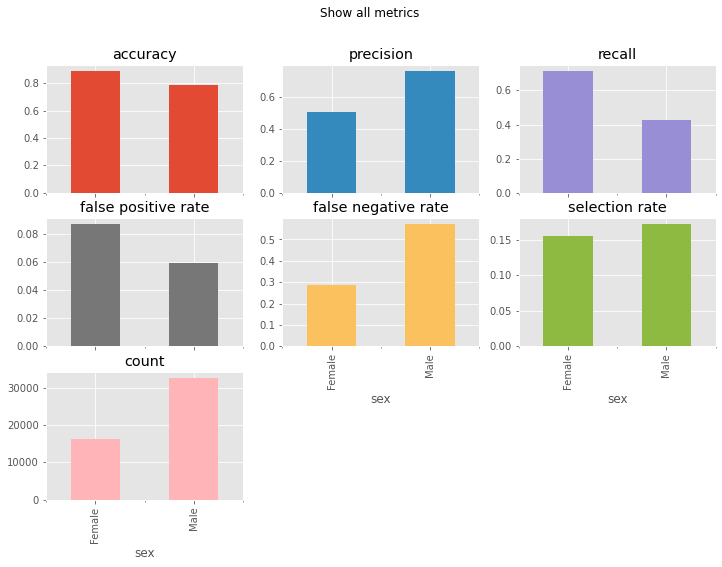

In [50]:
# Get metrics by sex
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred_mitigated,
                           sensitive_features=sex)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## Morris Sensitivity Analysis (InterpretML library will not work well in cloud environment)
For screening which inputs are important enough for further analysis.

source: https://interpret.ml/docs/msa.html

In [82]:
%%time
seed = 1

# fit blackbox model
pca = PCA()
blackbox_model = Pipeline([('pca', pca), ('classifier', classifier)])
blackbox_model.fit(X, y_true)

# show morris interpreted
msa = MorrisSensitivity(predict_fn=blackbox_model.predict_proba, data=X)
msa_global = msa.explain_global()
show(msa_global)

/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



<!-- http://127.0.0.1:7001/139725417998944/ -->

CPU times: user 8.37 s, sys: 345 ms, total: 8.71 s
Wall time: 9.13 s


#### Unfortunately InterpretML output doesn't work well in a cloud environment

## Using FairML to assess feature dependence
source: https://github.com/adebayoj/fairml

CPU times: user 2min 59s, sys: 1min 1s, total: 4min
Wall time: 4min 16s


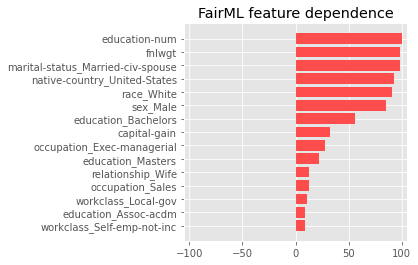

In [45]:
%%time
seed = 1

# fit blackbox model
X_meta = X
pca = PCA()
blackbox_model = Pipeline([('pca', pca), ('classifier', classifier)])
blackbox_model.fit(X_meta, y_true)

#  call audit model with model
total, _ = audit_model(blackbox_model.predict, X_meta)

# generate feature dependence plot
fig = plot_dependencies(
    dict(sorted(total.median().items(), key=lambda x: x[1], reverse=True)[:15]) ,
    reverse_values=False,
    title="FairML feature dependence"
)
plt.savefig("fairml_ldp.eps", transparent=False, bbox_inches='tight')

In [46]:
dict(sorted(total.median().items(), key=lambda x: x[1], reverse=True)[:15])

{'education-num': 0.12192375414602187,
 'fnlwgt': 0.12032676794562057,
 'marital-status_Married-civ-spouse': 0.11975349084804061,
 'native-country_United-States': 0.11281274313091191,
 'race_White': 0.11006920273535073,
 'sex_Male': 0.1031898775643913,
 'education_Bachelors': 0.06813807788378855,
 'capital-gain': 0.039638016461242376,
 'occupation_Exec-managerial': 0.03361860693665288,
 'education_Masters': 0.02647311739895991,
 'relationship_Wife': 0.01584701691167438,
 'occupation_Sales': 0.01545800745260227,
 'workclass_Local-gov': 0.013676753613693133,
 'education_Assoc-acdm': 0.011281274313091193,
 'workclass_Self-emp-not-inc': 0.011015109946357644}